## Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag
from models import linear_regression, VAE

%matplotlib inline

2025-02-14 08:02:43.699627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 08:02:43.829371: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 08:02:44.310275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-14 08:02:44.310350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [3]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [4]:
from numpy.random import seed
seed(1)
keras.utils.set_random_seed(1)

In [5]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

In [6]:
def load_pupil(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    pupil = medfilt(pupil,21)
    
    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        pupil = signal.sosfiltfilt(sos, pupil, axis=0)
    
    pupil = pupil[1000:-800,:]
    
    pupil = StandardScaler(with_std=False).fit_transform(pupil)

    return pupil

In [7]:
def load_brain(subj,modality='jrgeco',filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_' + modality + '.mat')
    brain = data_dict['data'][:,mask_long]

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        brain = signal.sosfiltfilt(sos, brain, axis=0)
        
    brain = brain[1000:-800,:]
    
    brain = StandardScaler(with_std=False).fit_transform(brain)

    return brain

In [8]:
def load_face(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_face.mat')
    face = data_dict['face'].reshape(-1,1)
    face = medfilt(face,21)

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        face = signal.sosfiltfilt(sos, face, axis=0)
    
    face = face[1000:-800,:]
    
    face = StandardScaler(with_std=False).fit_transform(face)

    return face

In [9]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/Allen'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [10]:
subjects = [4,5,6,7,8,9,10]
delay = 1 # implement delay embedding? 0 or 1
nonlinear = 1 # use nonlinear mappings (VAE) (as opposed to linear regression) ? 0 or 1
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 2 # number of latent dimensions used for VAE
num_epochs = 200 # number of training epochs
lr = .01 # learning rate
beta = 1 # beta weight for KL loss in VAE training
anneal_step = 200 # determines rate at which KL loss is increased during training
pretrained_enc = outdir + '/group_encoder_weights.h5' # pretrained encoder

# jrGECO

In [11]:
decoders = []
modality = 'jrgeco'

for s in range(len(subjects)):
    
    tic()
    
    print(str(s))
    
    subj = subjects[s]

    # Load data
    pupil = load_pupil(subj)
    face = load_face(subj)
    brain = load_brain(subj,modality)
       
    # Time delay embedding    
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    
    x = Hp.T@polys
    x = np.concatenate((x,Hp.T[:,-1:]),axis=1)
    y = np.concatenate((pupil,face,brain),axis=1)
    y = y[spacing*(stackmax-1):,:]
            
    # Adjust
    lag = 1 # in seconds
    lag = lag*Fs
    x = x[lag:,:]
    y = y[:-lag,:]

    # Preprocessing    
    x_sc, scale_x = scaler(x)
    y_sc, scale_y = scaler(y)

    # Train model
    r_squared, model, encoder, decoder = VAE(x_sc, y_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs,
                                             anneal_step=anneal_step, lr=lr,pretrained_encoder=pretrained_enc,
                                             verbose=False)

    decoders.append(decoder)
    
    print('Finished mouse ' + str(s+1) + '/' + str(len(subjects)))
    
    toc()

0


2025-02-14 08:02:54.265598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 08:02:54.814264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Finished mouse 1/7
Elapsed time is 40.7354896068573 seconds.
1
Finished mouse 2/7
Elapsed time is 38.4253625869751 seconds.
2
Finished mouse 3/7
Elapsed time is 37.35686373710632 seconds.
3
Finished mouse 4/7
Elapsed time is 38.11983609199524 seconds.
4
Finished mouse 5/7
Elapsed time is 38.86836886405945 seconds.
5
Finished mouse 6/7
Elapsed time is 37.90616989135742 seconds.
6
Finished mouse 7/7
Elapsed time is 37.56854486465454 seconds.


In [12]:
#sanity check..
r2_score(scale_y.inverse_transform(y_sc),scale_y.inverse_transform(model.predict(x_sc)),multioutput='variance_weighted')

0.9837992095617968

## Visualize latent space

In [13]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = .75
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

Z = np.zeros((num_bins,num_bins,10402)) #y.shape
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))
    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((xx[:,i],yy[:,i])).T,verbose=False)
    j+=1
    
toc()

Decoder 1/7
Decoder 2/7
Decoder 3/7
Decoder 4/7
Decoder 5/7
Decoder 6/7
Decoder 7/7
Elapsed time is 38.42766809463501 seconds.


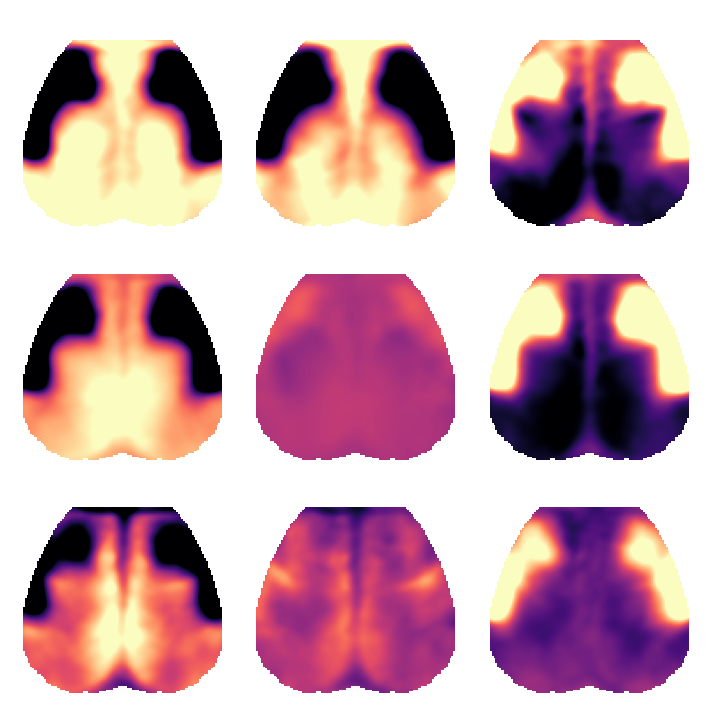

In [14]:
outmat = np.zeros((16384,1), dtype=np.single)
outmat = np.ma.masked_where(~mask_long.reshape(-1,1), outmat)

num_plots = 3

fig, axes = plt.subplots(num_plots,num_plots,sharex='col',figsize=(7,7),layout='compressed')

cmap = plt.colormaps['magma']

axes = axes.flatten()

max_row = num_bins - 1
plot_inds = np.linspace(0, num_bins-1, num_plots, dtype=int)

for i, ax in enumerate(axes):
    ii = i // num_plots  # row index
    j = i % num_plots   # column index
    
    outmat[mask_long] = Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1) \
                        - np.mean(Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1))

    temp = outmat.reshape(128, 128, order='F')
    
    ax.imshow(temp, vmin=-3, vmax=3, cmap=cmap)
    ax.axis('off')
    
plt.savefig(figdir + '/manifold_jrgeco.pdf', dpi=300, transparent=True)
    
plt.show()

# FAD

In [15]:
decoders = []
modality = 'fad'

for s in range(len(subjects)):
    
    tic()
    
    print(str(s))
    
    subj = subjects[s]

    # Load data
    pupil = load_pupil(subj)
    face = load_face(subj)
    brain = load_brain(subj,modality)
       
    # Time delay embedding    
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    
    x = Hp.T@polys
    x = np.concatenate((x,Hp.T[:,-1:]),axis=1)
    y = np.concatenate((pupil,face,brain),axis=1)
    y = y[spacing*(stackmax-1):,:]
            
    # Adjust
    lag = 1 # in seconds
    lag = lag*Fs
    x = x[lag:,:]
    y = y[:-lag,:]

    # Preprocessing    
    x_sc, scale_x = scaler(x)
    y_sc, scale_y = scaler(y)

    # Train model
    r_squared, model, encoder, decoder = VAE(x_sc, y_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs,
                                             anneal_step=anneal_step, lr=lr,pretrained_encoder=pretrained_enc,
                                             verbose=False)

    decoders.append(decoder)
    
    print('Finished mouse ' + str(s+1) + '/' + str(len(subjects)))
    
    toc()

0
Finished mouse 1/7
Elapsed time is 37.94160866737366 seconds.
1
Finished mouse 2/7
Elapsed time is 38.33871841430664 seconds.
2
Finished mouse 3/7
Elapsed time is 37.71108865737915 seconds.
3
Finished mouse 4/7
Elapsed time is 38.52117848396301 seconds.
4
Finished mouse 5/7
Elapsed time is 39.04523468017578 seconds.
5
Finished mouse 6/7
Elapsed time is 39.06244611740112 seconds.
6
Finished mouse 7/7
Elapsed time is 38.497562885284424 seconds.


## Visualize latent space

In [16]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = .75
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

Z = np.zeros((num_bins,num_bins,10402)) #y.shape
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))
    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((xx[:,i],yy[:,i])).T,verbose=False)
    j+=1
toc()

Decoder 1/7
Decoder 2/7
Decoder 3/7
Decoder 4/7
Decoder 5/7
Decoder 6/7
Decoder 7/7
Elapsed time is 39.0902898311615 seconds.


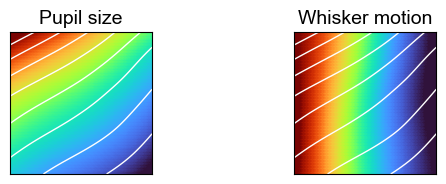

In [17]:
fig, ax = plt.subplots(1,2,figsize=(5.5, 3))
ax = ax.ravel()
fig.subplots_adjust(wspace=1)

titles=['Pupil size','Whisker motion']

for v in range(2):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=.9*np.min(z), vmax=.9*np.max(z))

    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]),10)
    ax[v].contour(xx, yy, Z[:,:,0], levels, colors='w', linestyles='solid',linewidths=1)

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=14, **{'fontname':'Arial'})

plt.savefig(figdir + '/manifold_pupil_whisk.pdf', dpi=300, transparent=True)
   
plt.show()

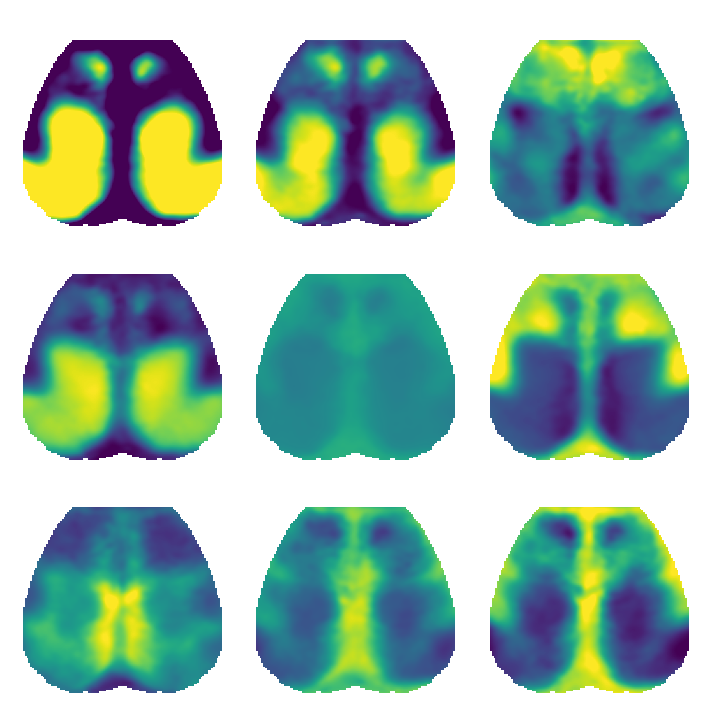

In [18]:
outmat = np.zeros((16384,1), dtype=np.single)
outmat = np.ma.masked_where(~mask_long.reshape(-1,1), outmat)

num_plots = 3

fig, axes = plt.subplots(num_plots,num_plots,sharex='col',figsize=(7,7),layout='compressed')

cmap = plt.colormaps['viridis']

axes = axes.flatten()

max_row = num_bins - 1
plot_inds = np.linspace(0, num_bins-1, num_plots, dtype=int)

for i, ax in enumerate(axes):
    ii = i // num_plots  # row index
    j = i % num_plots   # column index
    
    outmat[mask_long] = Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1) \
                        - np.mean(Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1))

    temp = outmat.reshape(128, 128, order='F')
    
    ax.imshow(temp, vmin=-7, vmax=7, cmap=cmap)
    ax.axis('off')
    
plt.savefig(figdir + '/manifold_fad.pdf', dpi=300, transparent=True)
    
plt.show()

# Hemoglobin

In [19]:
decoders = []
modality = 'hemo1'

for s in range(len(subjects)):
    
    tic()
    
    print(str(s))
    
    subj = subjects[s]

    # Load data
    pupil = load_pupil(subj)
    face = load_face(subj)
    brain = load_brain(subj,modality)
       
    # Time delay embedding    
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    
    x = Hp.T@polys
    x = np.concatenate((x,Hp.T[:,-1:]),axis=1)
    y = np.concatenate((pupil,face,brain),axis=1)
    y = y[spacing*(stackmax-1):,:]
            
    # Adjust
    lag = 1 # in seconds
    lag = lag*Fs
    x = x[lag:,:]
    y = y[:-lag,:]

    # Preprocessing    
    x_sc, scale_x = scaler(x)
    y_sc, scale_y = scaler(y)

    # Train model
    r_squared, model, encoder, decoder = VAE(x_sc, y_sc, latent_dim=z_n, beta=beta, num_epochs=num_epochs,
                                             anneal_step=anneal_step, lr=lr,pretrained_encoder=pretrained_enc,
                                             verbose=False)

    decoders.append(decoder)
    
    print('Finished mouse ' + str(s+1) + '/' + str(len(subjects)))
    
    toc()

0
Finished mouse 1/7
Elapsed time is 37.728331089019775 seconds.
1
Finished mouse 2/7
Elapsed time is 38.19153094291687 seconds.
2
Finished mouse 3/7
Elapsed time is 37.69635367393494 seconds.
3
Finished mouse 4/7
Elapsed time is 38.46916174888611 seconds.
4
Finished mouse 5/7
Elapsed time is 38.4714994430542 seconds.
5
Finished mouse 6/7
Elapsed time is 38.1052782535553 seconds.
6
Finished mouse 7/7
Elapsed time is 38.54810166358948 seconds.


## Visualize latent space

In [20]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = .75
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

Z = np.zeros((num_bins,num_bins,10402)) #y.shape
tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))
    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((xx[:,i],yy[:,i])).T,verbose=False)
    j+=1
toc()

Decoder 1/7
Decoder 2/7
Decoder 3/7
Decoder 4/7
Decoder 5/7
Decoder 6/7
Decoder 7/7
Elapsed time is 38.59014534950256 seconds.


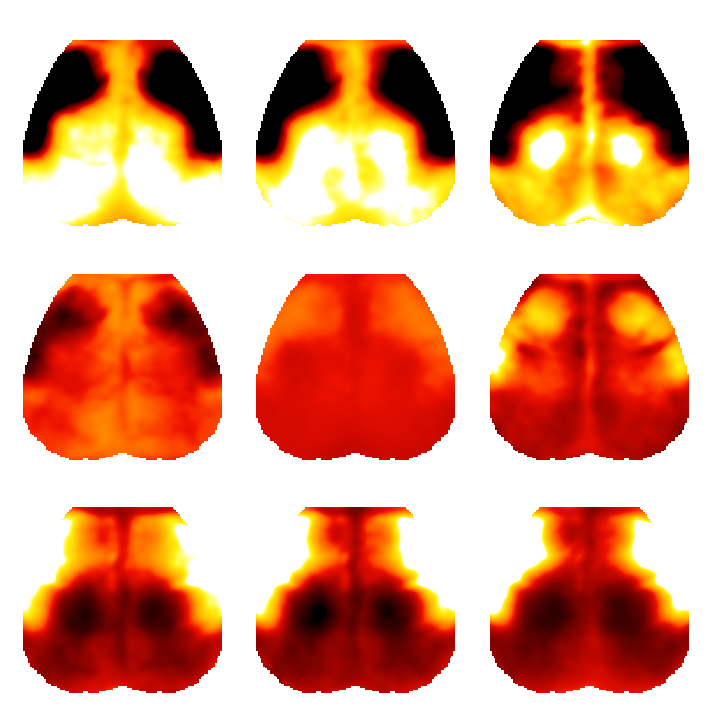

In [21]:
outmat = np.zeros((16384,1), dtype=np.single)
outmat = np.ma.masked_where(~mask_long.reshape(-1,1), outmat)

num_plots = 3

fig, axes = plt.subplots(num_plots,num_plots,sharex='col',figsize=(7,7),layout='compressed')

cmap = cc.cm.CET_L3.copy()

axes = axes.flatten()

max_row = num_bins-1
plot_inds = np.linspace(0, num_bins-1, num_plots, dtype=int)

for i, ax in enumerate(axes):
    ii = i // num_plots  # row index
    j = i % num_plots   # column index
    
    outmat[mask_long] = Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1) \
                        - np.mean(Z[max_row-plot_inds[ii],plot_inds[j],2:].reshape(-1,1))

    temp = outmat.reshape(128, 128, order='F')
    
    ax.imshow(temp, vmin=-4.2, vmax=4.2, cmap=cmap)
    ax.axis('off')
    
plt.savefig(figdir + '/manifold_hemo.pdf', dpi=300, transparent=True)
    
plt.show()